Cluster Interconnectivity Analysis Script

This script analyzes and visualizes the interconnectivity between academic paper clusters.
It processes citation networks to show how different research clusters reference each other,
creating matrices and heatmap visualizations.

The script:

1. Loads cluster and reference data from pickle and JSON files
2. Creates interconnectivity matrices showing citation patterns between clusters
3. Analyzes internal vs. external reference patterns for each cluster
4. Generates heatmap visualizations of the interconnectivity

Requirements:

- Environment variables in .env file: DATA_DIR, OUTPUT_DIR
- Input data:
  - Pickled DataFrame with cluster assignments and reference data
  - JSON files with cluster labels and legend information

Author: Lukas Westphal
Date: April 16, 2025


In [1]:
import json
import os
from collections import defaultdict
from datetime import datetime
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

from pandas import Timestamp

In [73]:
class ClusterAnalyzer:
    """
    Class to handle cluster analysis operations.

    This class provides methods for analyzing interconnectivity between
    academic paper clusters based on citation networks. It loads data,
    extracts cluster categories, creates interconnectivity matrices,
    analyzes reference patterns, and generates visualizations.

    The analysis focuses on how different research clusters reference each other,
    measuring both internal (within-cluster) and external (between-cluster) citation
    patterns to identify knowledge flow and research community structures.
    """

    def __init__(
        self, data_dir: str, output_dir: str, parameter: str = "alpha0.3_k10_res0.002"
    ):
        """Initialize with paths and parameters."""
        self.data_dir = data_dir
        self.output_dir = output_dir
        self.parameter = parameter
        self.cluster_col = f"cluster_{parameter}"
        self.df = None
        self.cluster_label_dict = None
        self.legend = None

    def load_data(self):
        """
        Load the dataset and reference files.

        This method loads the main DataFrame, cluster labels, and legend files
        required for the analysis. It ensures that all necessary data is available
        for subsequent operations.

        Returns:
            self: The ClusterAnalyzer instance with loaded data.
        """
        # Load DataFrame
        pdf = os.path.join(self.data_dir, "08-analysis-data/df_analysis.pkl")
        self.df = pd.read_pickle(pdf)
        print(f"DataFrame loaded with rows: {len(self.df)}")

        # Load cluster labels
        labels_path = os.path.join(
            self.output_dir,
            "cluster-qualifications_2025/cluster-label-tree/cluster_labels_filtered.json",
        )
        with open(labels_path, "r") as f:
            self.cluster_label_dict = json.load(f)
        print(f"Cluster labels loaded with {len(self.cluster_label_dict)} entries.")

        # Load legend
        legend_path = os.path.join(
            self.output_dir,
            "cluster-qualifications_2025/cluster-label-tree/legend_labels_2025.json",
        )
        with open(legend_path, "r") as f:
            self.legend = json.load(f)
        print(f"Legend loaded with {len(self.legend)} entries.")
        return self

    @staticmethod
    def _get_dict_keys(obj):
        """Extract all dictionary keys from nested structures."""
        if isinstance(obj, dict):
            # Get keys from current level and recurse for nested structures
            return list(obj.keys()) + [
                k for v in obj.values() for k in ClusterAnalyzer._get_dict_keys(v)
            ]
        elif isinstance(obj, list):
            # Recurse for each item in the list
            return [k for item in obj for k in ClusterAnalyzer._get_dict_keys(item)]
        else:
            # Base case: not a dict or list
            return []

    def create_cluster_interconnectivity_matrix(
        self, cluster_subset_keys=None
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Create matrices showing the interconnectivity between clusters.
        Treats connections as undirected, so an edge between cluster A and B
        is counted in both directions.

        Args:
            cluster_subset_keys (list, optional): A subset of cluster keys to limit the calculation.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]:
                - Edge counts matrix (raw counts)
                - Normalized interconnectivity matrix
        """
        # Get unique clusters and create mappings
        clusters = sorted(self.df[self.cluster_col].unique(), key=int)

        # Filter clusters if a subset is provided
        if cluster_subset_keys is not None:
            clusters = [c for c in clusters if int(c) in cluster_subset_keys]
        n_clusters = len(clusters)

        if n_clusters == 0:
            raise ValueError("No clusters found in the data or the subset provided.")

        # Create a mapping of eid to cluster for faster lookups
        eid_to_cluster = self.df.set_index("eid")[self.cluster_col].to_dict()

        # Create a mapping of cluster to index for faster lookups
        cluster_to_idx = {cluster: idx for idx, cluster in enumerate(clusters)}

        # Initialize edge count matrix
        edge_counts = np.zeros((n_clusters, n_clusters))

        # Pre-process and organize all references by source cluster
        references_by_cluster = defaultdict(list)

        # Build a list of all references with their source clusters
        for _, row in self.df.iterrows():
            if row[self.cluster_col] in clusters:  # Only process rows in the subset
                cluster_idx = cluster_to_idx[row[self.cluster_col]]
                if isinstance(row["filtered_reference_eids"], list):
                    references_by_cluster[cluster_idx].extend(
                        row["filtered_reference_eids"]
                    )
                else:
                    print(
                        f"Unexpected reference type: {type(row['filtered_reference_eids'])}"
                    )

        # Process all references at once per cluster
        for src_cluster_idx, reference_eids in references_by_cluster.items():
            # Filter references to only those in our dataset and subset
            valid_refs = [
                eid
                for eid in reference_eids
                if eid in eid_to_cluster and eid_to_cluster[eid] in clusters
            ]

            if valid_refs:
                # Get the target clusters for all references
                target_clusters = [eid_to_cluster[eid] for eid in valid_refs]

                # Convert target clusters to indices
                target_indices = [cluster_to_idx[c] for c in target_clusters]

                # Count occurrences of each target cluster in both directions to make undirected
                for tgt_idx in target_indices:
                    # Increment count in both directions to make the graph undirected
                    edge_counts[src_cluster_idx, tgt_idx] += 1
                    edge_counts[
                        tgt_idx, src_cluster_idx
                    ] += 1  # Add count in reverse direction

        # Create DataFrames with sorted cluster labels
        cluster_labels = [f"Cluster {c}" for c in clusters]
        edge_counts_df = pd.DataFrame(
            edge_counts, index=cluster_labels, columns=cluster_labels
        )

        # Calculate cluster sizes once (more efficient)
        cluster_sizes = self.df[self.cluster_col].value_counts()
        # Sort the index numerically and filter by subset
        cluster_sizes = cluster_sizes.reindex(sorted(cluster_sizes.index, key=int))
        cluster_sizes = cluster_sizes[cluster_sizes.index.isin(clusters)].values

        # Create normalized matrix using broadcasting
        normalized_counts = np.zeros((n_clusters, n_clusters))
        size_matrix = np.outer(cluster_sizes, cluster_sizes)
        mask = size_matrix > 0
        normalized_counts[mask] = edge_counts[mask] / size_matrix[mask]

        normalized_df = pd.DataFrame(
            normalized_counts, index=cluster_labels, columns=cluster_labels
        )

        return edge_counts_df, normalized_df

    def analyze_cluster_interconnectivity(self) -> Dict[str, Dict[str, float]]:
        """
        Analyze the interconnectivity between clusters.

        Returns:
            Dict[str, Dict[str, float]]: Metrics for each cluster, including internal and external ratios.
        """
        # Get unique clusters
        clusters = sorted(self.df[self.cluster_col].unique())

        # Create a mapping of eid to cluster for faster lookups
        eid_to_cluster = self.df.set_index("eid")[self.cluster_col].to_dict()

        # Pre-compute all edge information at once
        edge_data = defaultdict(lambda: {"internal": 0, "external": 0})

        # Group by cluster for more efficient processing
        cluster_groups = self.df.groupby(self.cluster_col)

        for cluster, cluster_df in cluster_groups:
            # Process all rows in a cluster at once
            for _, row in cluster_df.iterrows():
                if (
                    isinstance(row["filtered_reference_eids"], list)
                    and row["filtered_reference_eids"]
                ):
                    # Filter to valid references
                    valid_refs = [
                        eid
                        for eid in row["filtered_reference_eids"]
                        if eid in eid_to_cluster
                    ]

                    if valid_refs:
                        # Get target clusters for all references at once
                        target_clusters = [eid_to_cluster[eid] for eid in valid_refs]

                        # Count internal vs external references
                        internal_count = sum(1 for c in target_clusters if c == cluster)
                        external_count = len(target_clusters) - internal_count

                        edge_data[cluster]["internal"] += internal_count
                        edge_data[cluster]["external"] += external_count

        # Calculate metrics
        cluster_metrics = {}
        for cluster in clusters:
            internal_edges = edge_data[cluster]["internal"]
            external_edges = edge_data[cluster]["external"]
            total_edges = internal_edges + external_edges

            internal_ratio = internal_edges / total_edges if total_edges > 0 else 0
            external_ratio = external_edges / total_edges if total_edges > 0 else 0

            cluster_metrics[cluster] = {
                "size": len(self.df[self.df[self.cluster_col] == cluster]),
                "internal_edges": internal_edges,
                "external_edges": external_edges,
                "internal_ratio": internal_ratio,
                "external_ratio": external_ratio,
            }

        return cluster_metrics

    def print_metrics_summary(self, metrics_df):
        """Print summary statistics from metrics dataframe."""
        print("\nCluster Interconnectivity Summary:")
        print("-" * 50)
        print(f"Total number of clusters: {len(metrics_df)}")
        print(f"Average cluster size: {metrics_df['size'].mean():.2f}")
        print(f"Average internal edge ratio: {metrics_df['internal_ratio'].mean():.3f}")
        print(f"Average external edge ratio: {metrics_df['external_ratio'].mean():.3f}")

    def plot_heatmap(
        self,
        df_to_plot,
        cluster_type="All",
        diag_excluded=True,
        cap_max_percentile=None,
    ):
        """
        Plot heatmap for cluster interconnectivity.

        Args:
            df_to_plot (pd.DataFrame): DataFrame to visualize as a heatmap.
            cluster_type (str): Type of clusters to label the heatmap.
            diag_excluded (bool): Whether to exclude diagonal values.
            cap_max_percentile (float, optional): Maximum percentile for color scale.
        """
        # Set figure size based on matrix dimensions
        figsize = (25, 25) if cluster_type == "All" else (20, 15)

        # Create labels for axes
        clusters = [
            cluster.replace("Cluster ", "") for cluster in df_to_plot.index.tolist()
        ]
        x_labels = [self.cluster_label_dict[cluster] for cluster in clusters]
        y_labels = [self.cluster_label_dict[cluster] for cluster in clusters]

        # Exclude diagonal if specified
        if diag_excluded:
            np.fill_diagonal(df_to_plot.values, np.nan)

        # Set maximum value for color scale
        if cap_max_percentile:
            vmax = np.nanpercentile(df_to_plot.values, cap_max_percentile)
        else:
            vmax = df_to_plot.max().max()

        # Create plot
        plt.figure(figsize=figsize)
        heatmap = sns.heatmap(
            df_to_plot,
            annot=False,
            xticklabels=x_labels,
            yticklabels=y_labels,
            cmap="viridis",
            vmin=0,
            vmax=vmax,
            cbar_kws={"label": "Interconnectivity"},
        )

        title = f"Undirected Edge Counts Between {cluster_type} Clusters"
        plt.title(title)
        plt.xlabel("Clusters")
        plt.ylabel("Clusters")
        plt.tight_layout()

        # Save figure
        heatmap_filename = f"heatmap_undirected_{cluster_type}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        output_path = self.output_dir
        plt.savefig(os.path.join(output_path, heatmap_filename), dpi=400)
        plt.show()
        plt.close()

In [74]:
"""
Main function to run the cluster interconnectivity analysis.

This function:
1. Loads environment variables from .env file
2. Initializes the ClusterAnalyzer with appropriate paths
3. Loads data and extracts cluster categories
4. Creates interconnectivity matrices
5. Analyzes cluster interconnectivity metrics
6. Generates visualizations for all clusters and safety clusters

The function orchestrates the entire analysis pipeline and produces
both numerical metrics and visual heatmaps showing citation patterns.
"""

# Load environment variables

load_dotenv()

# Access environment variables
data_dir = os.getenv("DATA_DIR")
output_dir = os.getenv("OUTPUT_DIR")

In [75]:
# Initialize analyzer
analyzer = ClusterAnalyzer(data_dir, output_dir)

# load analyses
analyzer.load_data()

# Create interconnectivity matrices
edge_counts_df, normalized_df = analyzer.create_cluster_interconnectivity_matrix()
print("Edge counts matrix created successfully")

# Analyze cluster interconnectivity
cluster_metrics = analyzer.analyze_cluster_interconnectivity()

# Convert cluster metrics to DataFrame for easier analysis
metrics_df = pd.DataFrame.from_dict(cluster_metrics, orient="index")
metrics_df.index.name = "cluster"
metrics_df = metrics_df.sort_index()

# Print summary statistics
analyzer.print_metrics_summary(metrics_df)

DataFrame loaded with rows: 36510
Cluster labels loaded with 99 entries.
Legend loaded with 4 entries.
Edge counts matrix created successfully

Cluster Interconnectivity Summary:
--------------------------------------------------
Total number of clusters: 99
Average cluster size: 368.79
Average internal edge ratio: 0.498
Average external edge ratio: 0.502


In [77]:
edge_counts_df.head(2)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,...,Cluster 89,Cluster 90,Cluster 91,Cluster 92,Cluster 93,Cluster 94,Cluster 95,Cluster 96,Cluster 97,Cluster 99
Cluster 0,24472.0,294.0,424.0,18.0,125.0,29.0,279.0,111.0,50.0,6.0,...,16.0,1.0,8.0,3.0,57.0,0.0,3.0,2.0,29.0,6.0
Cluster 1,294.0,18300.0,193.0,343.0,97.0,89.0,306.0,1087.0,376.0,359.0,...,248.0,8.0,7.0,28.0,41.0,5.0,4.0,9.0,27.0,8.0


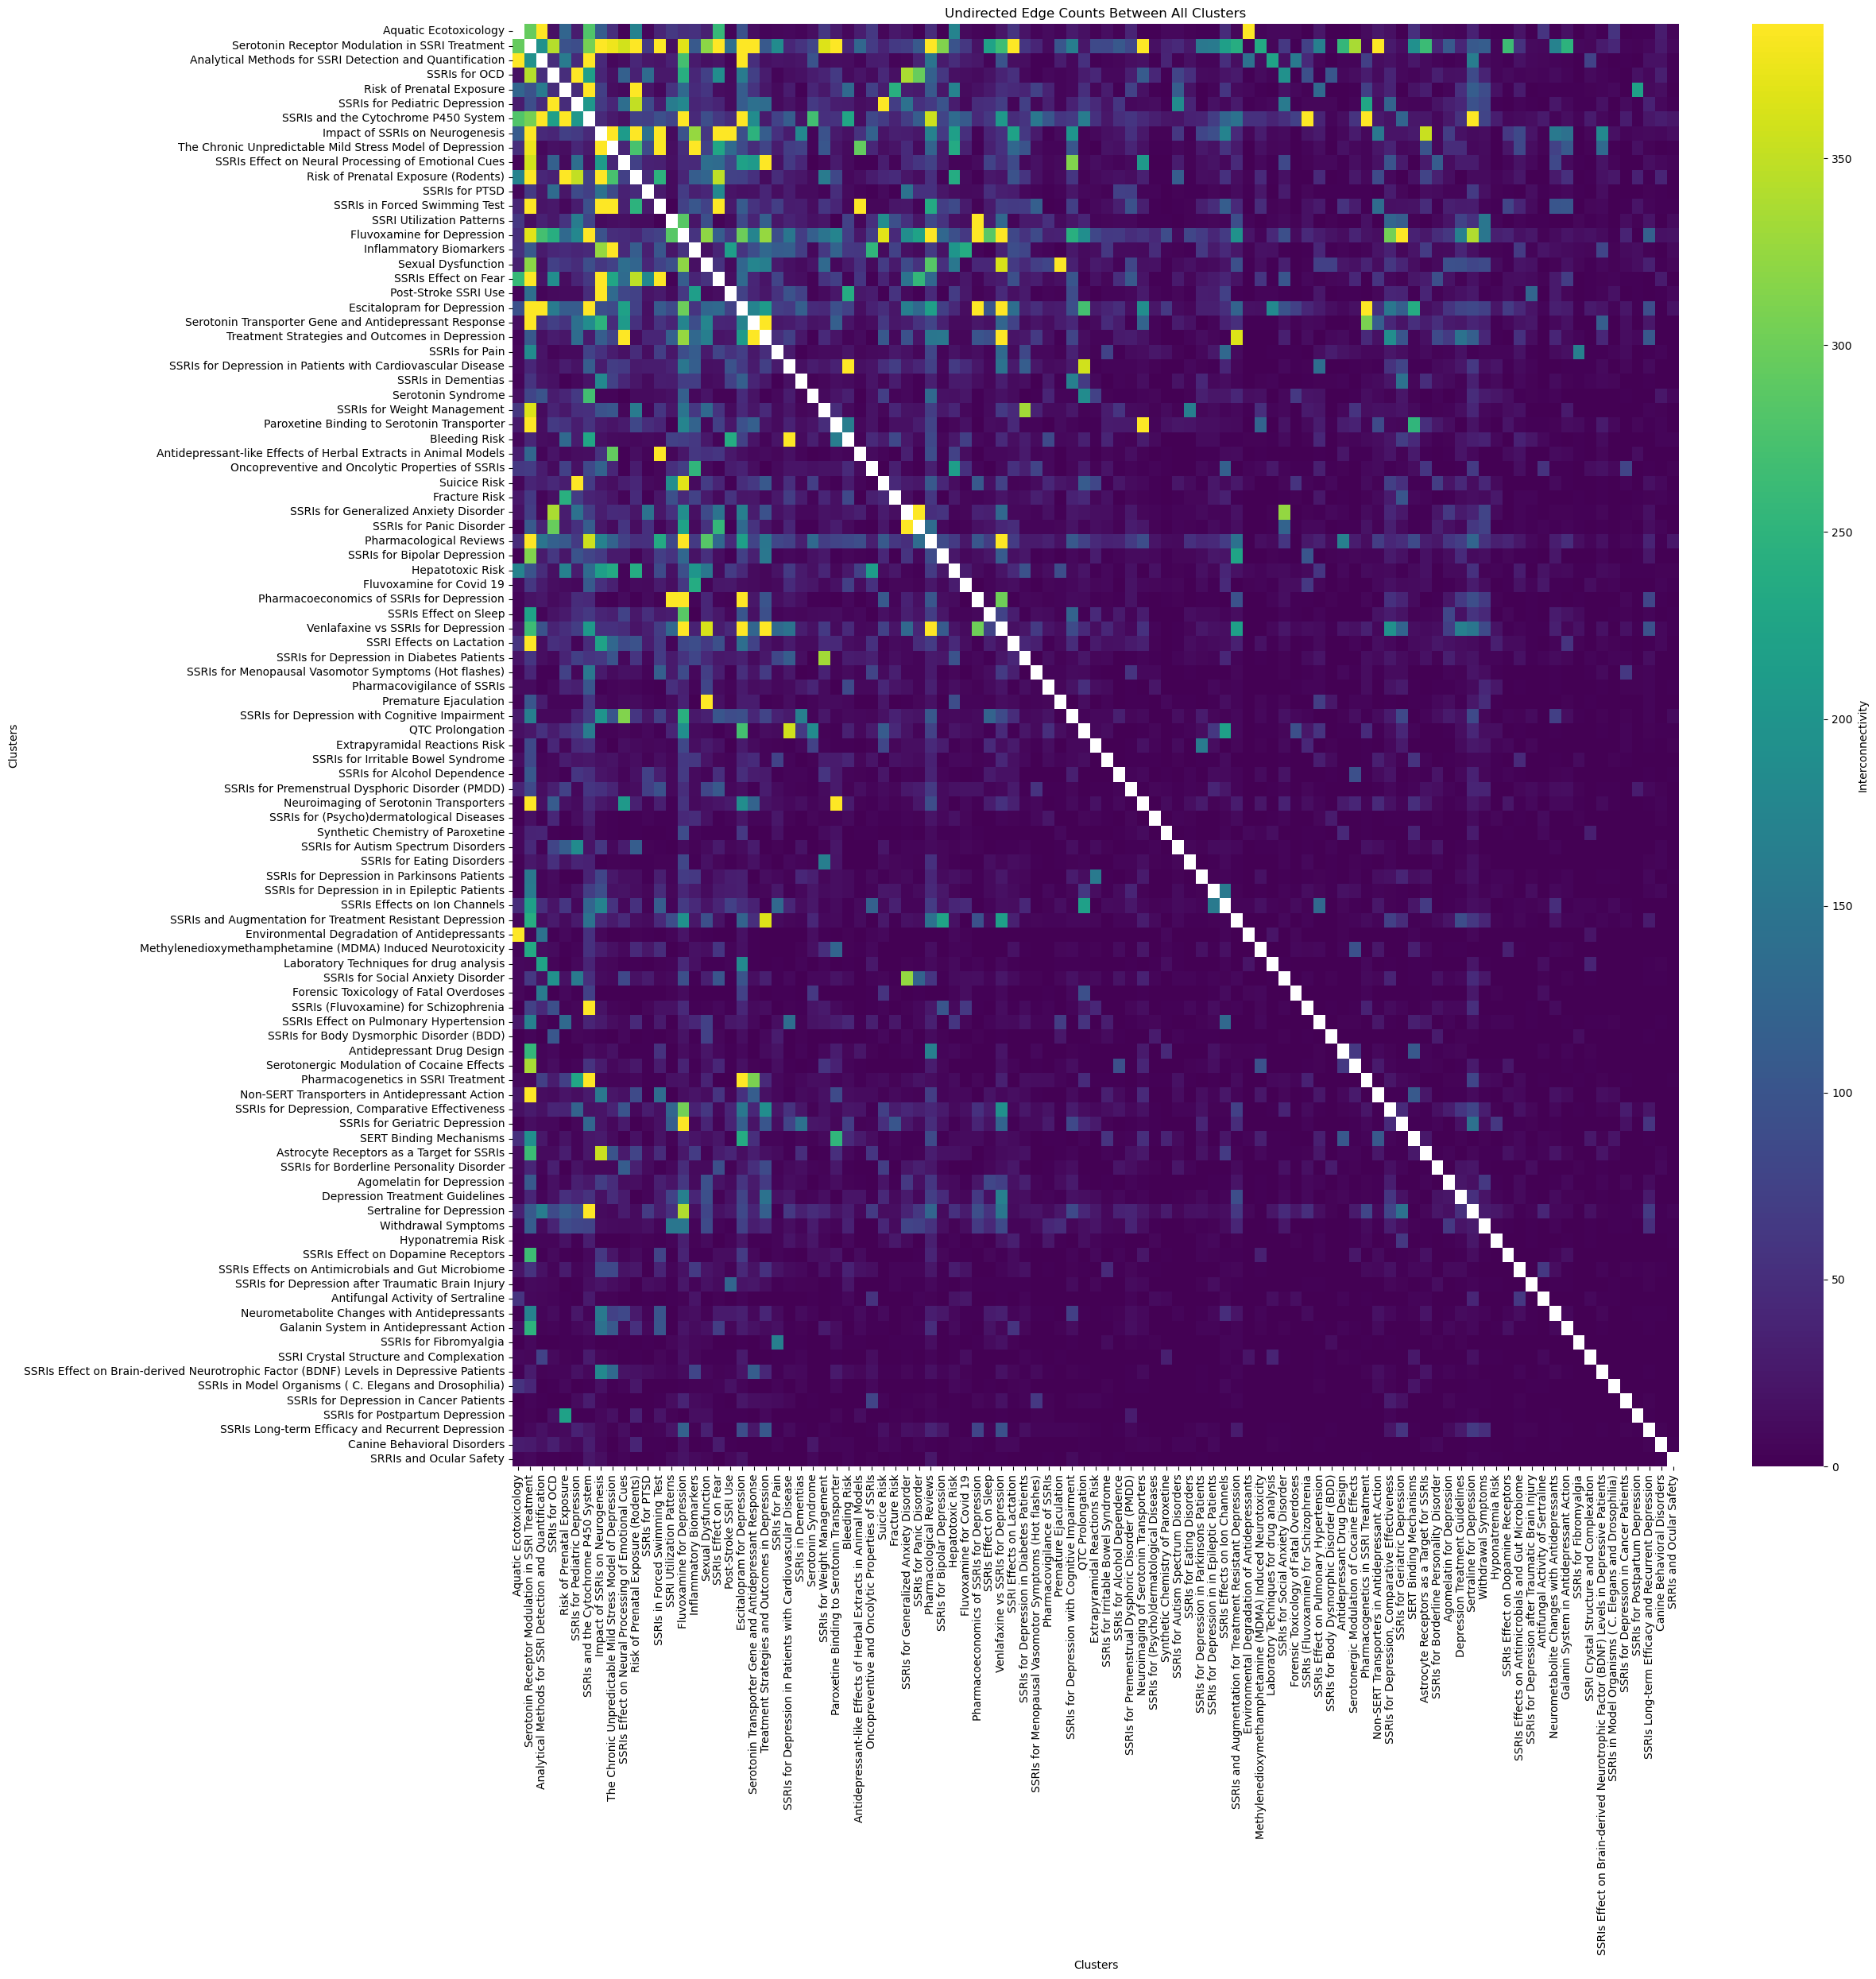

In [78]:
# Plot heatmap for all clusters
analyzer.plot_heatmap(edge_counts_df, "All", diag_excluded=True, cap_max_percentile=99)

# Subsets


In [79]:
def get_all_leaf_clusters(node, print_labels=False):
    """
    Recursively extracts all leaf cluster numbers from a hierarchical tree structure.

    Args:
        node: A dictionary or list node in the hierarchical tree

    Returns:
        list: A sorted list of all unique cluster numbers found in the leaves
    """
    clusters = []

    if isinstance(node, dict):
        # If this is a dictionary node, process each of its values
        for value in node.values():
            clusters.extend(get_all_leaf_clusters(value))

    elif isinstance(node, list):
        # If this is a list node, process each item in the list
        for item in node:
            clusters.extend(get_all_leaf_clusters(item))

    elif isinstance(node, dict) and len(node) == 1:
        # This is a leaf node with a single key-value pair
        # The key is the cluster number and the value is the description
        clusters.append(int(list(node.keys())[0]))

    # Handle the case where node is a dictionary with a single numeric key
    # This is the actual leaf node format in your data
    if (
        isinstance(node, dict)
        and len(node) == 1
        and all(k.isdigit() for k in node.keys())
    ):
        clusters.append(int(list(node.keys())[0]))

    if print_labels:
        for cluster in clusters:
            print(
                f"Cluster {cluster}: {cluster_label_dict.get(str(cluster), 'Unknown')}"
            )

    return sorted(list(set(clusters)))

In [80]:
# get legend

legend = analyzer.legend
# get cluster labels
cluster_label_dict = analyzer.cluster_label_dict
# get cluster label tree
cluster_label_tree = analyzer._get_dict_keys(cluster_label_dict)

In [81]:
# Get all leaf clusters from the Pharmacology branch
print("All clusters in Pharmacology:")
pharma_keys = get_all_leaf_clusters(
    legend["Pharmacology"]["Pharmacodynamics"]["Animal Models of Disorders"],
    print_labels=True,
)

All clusters in Pharmacology:
Cluster 8: The Chronic Unpredictable Mild Stress Model of Depression
Cluster 12: SSRIs in Forced Swimming Test
Cluster 17: SSRIs Effect on Fear
Cluster 71: Serotonergic Modulation of Cocaine Effects


In [82]:
print("All clusters in Geriatrics:")
geriatrics_keys = get_all_leaf_clusters(
    legend["Safety"]["Special Populations"]["Geriatrics"], print_labels=True
)

All clusters in Geriatrics:
Cluster 18: Post-Stroke SSRI Use
Cluster 23: SSRIs for Depression in Patients with Cardiovascular Disease
Cluster 24: SSRIs in Dementias
Cluster 47: SSRIs for Depression with Cognitive Impairment
Cluster 58: SSRIs for Depression in Parkinsons Patients
Cluster 75: SSRIs for Geriatric Depression


DataFrame loaded with rows: 36510
Cluster labels loaded with 99 entries.
Legend loaded with 4 entries.
Edge counts matrix created successfully

Cluster Interconnectivity Summary:
--------------------------------------------------
Total number of clusters: 99
Average cluster size: 368.79
Average internal edge ratio: 0.498
Average external edge ratio: 0.502


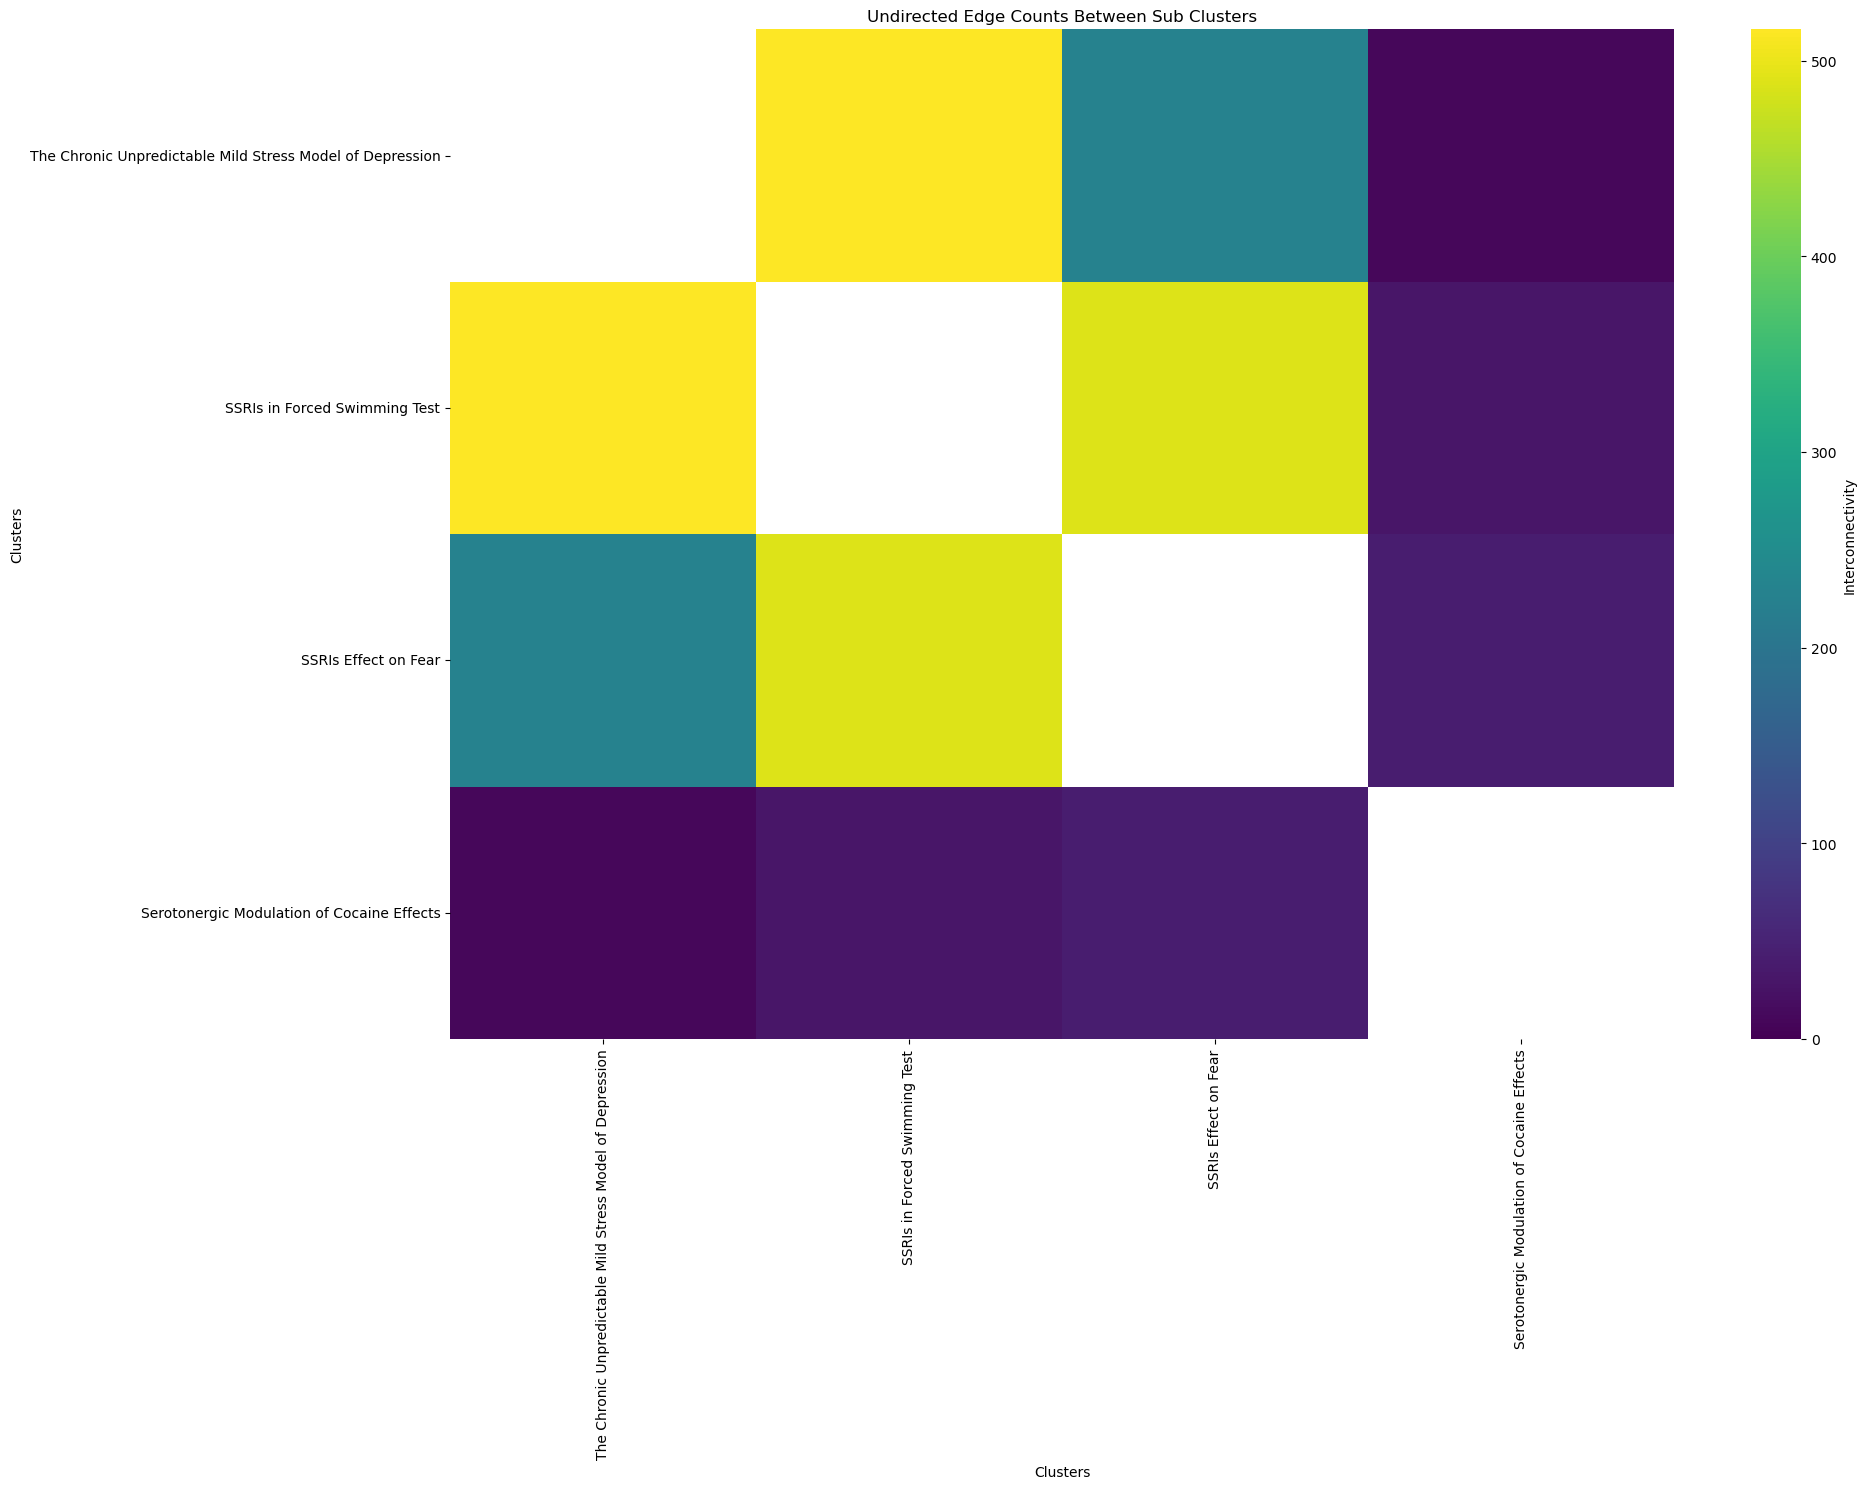

In [83]:
# Initialize analyzer
analyzer_subset = ClusterAnalyzer(data_dir, output_dir)

# load analyses
analyzer_subset.load_data()

# Create interconnectivity matrices
edge_counts_df_pharma, normalized_df_pharma = (
    analyzer_subset.create_cluster_interconnectivity_matrix(pharma_keys)
)
# Create interconnectivity matrices
print("Edge counts matrix created successfully")

# Analyze cluster interconnectivity
cluster_metrics_pharma = analyzer_subset.analyze_cluster_interconnectivity()

# Convert cluster metrics to DataFrame for easier analysis
cluster_metrics_pharma = pd.DataFrame.from_dict(cluster_metrics_pharma, orient="index")
cluster_metrics_pharma.index.name = "cluster"
cluster_metrics_pharma = cluster_metrics_pharma.sort_index()

# Print summary statistics
analyzer_subset.print_metrics_summary(metrics_df=cluster_metrics_pharma)
# Plot heatmap for pharma clusters
analyzer_subset.plot_heatmap(
    edge_counts_df_pharma, "Sub", diag_excluded=True, cap_max_percentile=99
)

DataFrame loaded with rows: 36510
Cluster labels loaded with 99 entries.
Legend loaded with 4 entries.
Edge counts matrix created successfully

Cluster Interconnectivity Summary:
--------------------------------------------------
Total number of clusters: 99
Average cluster size: 368.79
Average internal edge ratio: 0.498
Average external edge ratio: 0.502


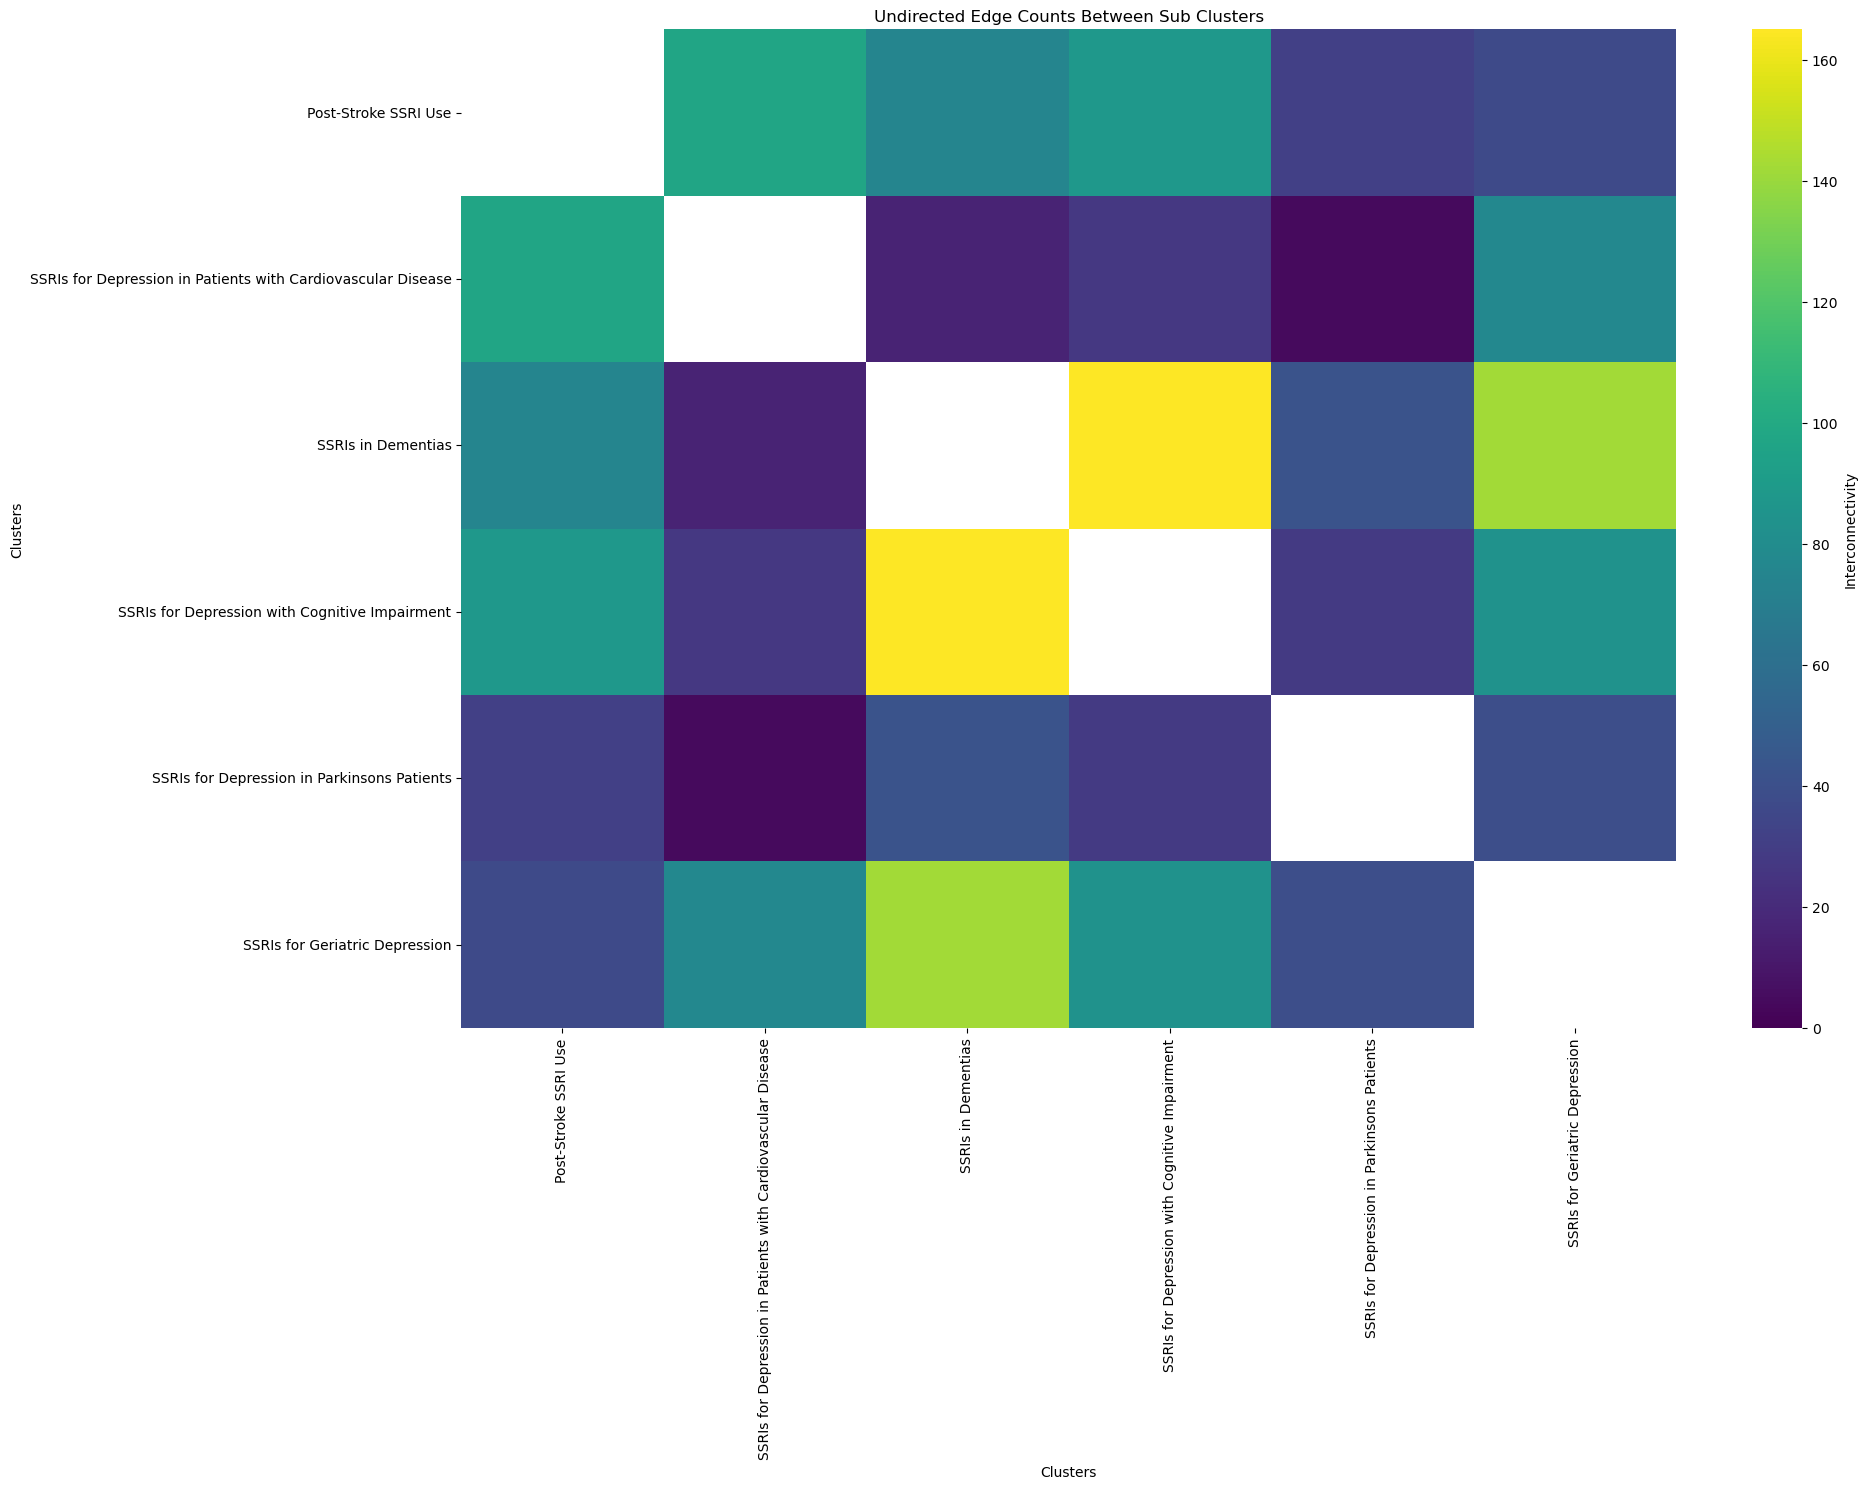

In [84]:
# Initialize analyzer
analyzer_geriatrics = ClusterAnalyzer(data_dir, output_dir)

# load analyses
analyzer_geriatrics.load_data()

# Create interconnectivity matrices
edge_counts_df_geriatrics, normalized_df_geriatrics = (
    analyzer_geriatrics.create_cluster_interconnectivity_matrix(geriatrics_keys)
)
# Create interconnectivity matrices
print("Edge counts matrix created successfully")

# Analyze cluster interconnectivity
cluster_metrics_geriatrics = analyzer_geriatrics.analyze_cluster_interconnectivity()

# Convert cluster metrics to DataFrame for easier analysis
cluster_metrics_geriatrics = pd.DataFrame.from_dict(
    cluster_metrics_geriatrics, orient="index"
)
cluster_metrics_geriatrics.index.name = "cluster"
cluster_metrics_geriatrics = cluster_metrics_geriatrics.sort_index()

# Print summary statistics
analyzer_geriatrics.print_metrics_summary(metrics_df=cluster_metrics_geriatrics)
# Plot heatmap for all clusters
analyzer_geriatrics.plot_heatmap(
    edge_counts_df_geriatrics, "Sub", diag_excluded=True, cap_max_percentile=99
)

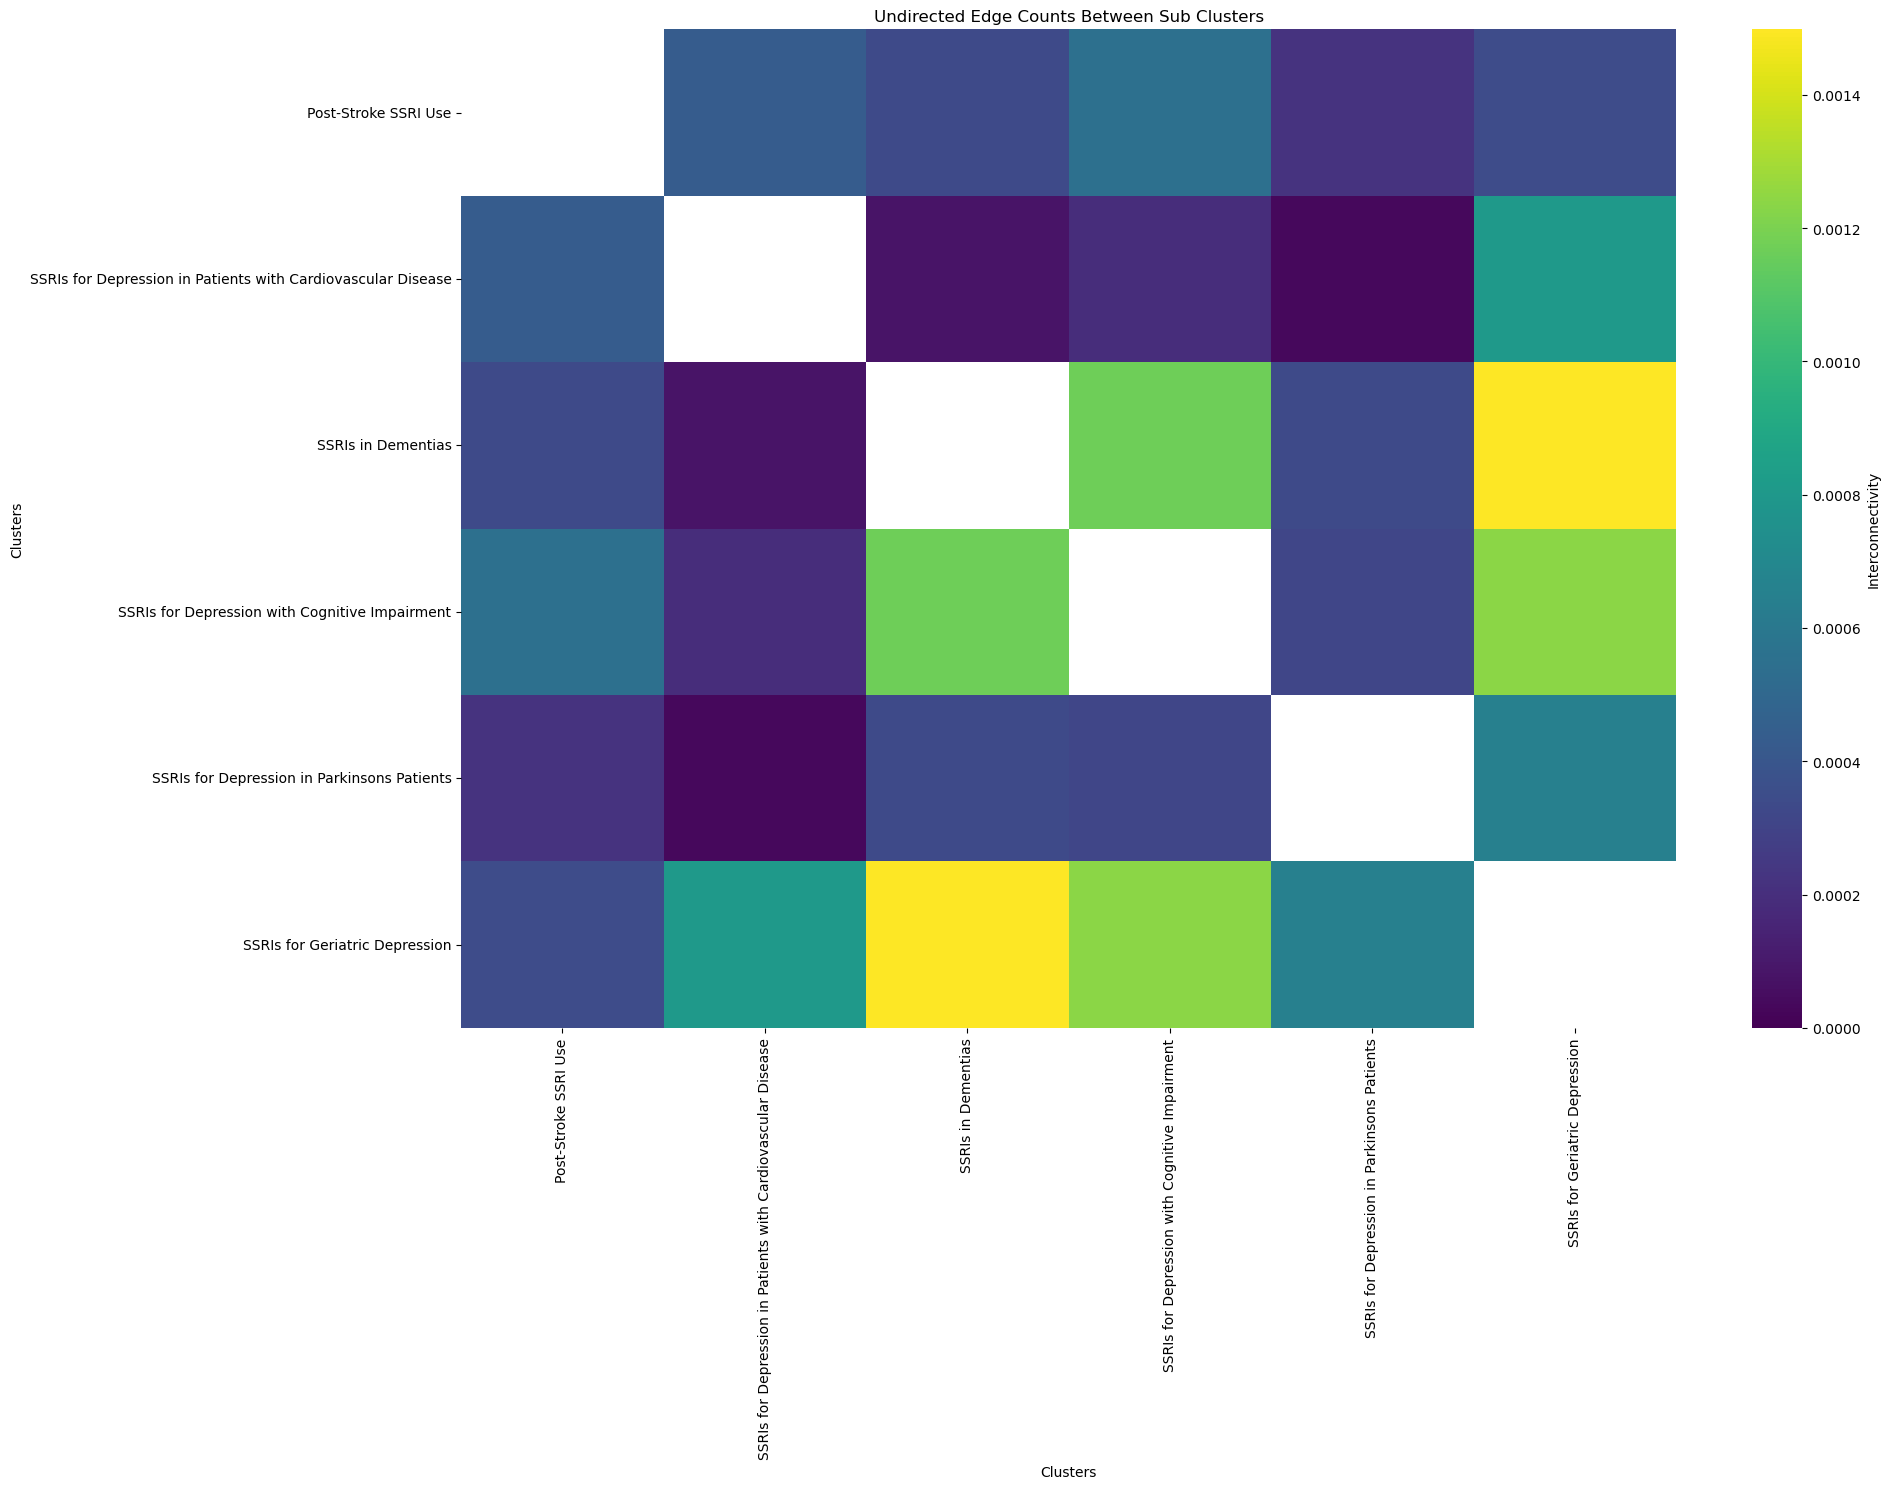

In [85]:
analyzer_geriatrics.plot_heatmap(
    normalized_df_geriatrics, "Sub", diag_excluded=True, cap_max_percentile=99
)

# Intra and Inter Connectedness of Clusters Over Time


In [166]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from datetime import datetime
from typing import Dict, List, Tuple, Union, Optional


class CitationTemporalAnalyzer:
    """
    A standalone class for analyzing and visualizing citation patterns between
    academic paper clusters over time.

    This class handles loading data, calculating citation metrics and network measures,
    and creating visualizations that show how research communities evolve in their
    citation patterns, with options to analyze either within closed subsets of
    clusters or considering all possible external connections.
    """

    def __init__(self, data_path: str, cluster_labels_path: str, output_dir: str):
        """
        Initialize the analyzer with paths to data and configuration.

        Args:
            data_path: Path to the main DataFrame pickle file
            cluster_labels_path: Path to cluster labels JSON file
            output_dir: Directory to save output visualizations
        """
        self.data_path = data_path
        self.cluster_labels_path = cluster_labels_path
        self.output_dir = output_dir

        # DataFrame columns
        self.cluster_col = None  # Will be set during load_data
        self.year_column = "year"  # Default year column
        self.reference_column = "filtered_reference_eids"  # Default reference column
        self.eid_column = "eid"  # Default paper ID column

        # Data stores
        self.df = None
        self.cluster_label_dict = None
        self.cluster_sizes = None
        self.years = None
        self.clusters = None

        # Results cache
        self._cached_results = {}

    def load_data(self, cluster_param: str = "alpha0.3_k10_res0.002"):
        """
        Load the dataset and cluster labels.

        Args:
            cluster_param: Parameter string used in cluster column name

        Returns:
            self: The analyzer instance with loaded data
        """
        # Set cluster column name
        self.cluster_col = f"cluster_{cluster_param}"

        # Load main dataframe
        print(f"Loading data from {self.data_path}...")
        self.df = pd.read_pickle(self.data_path)
        print(f"DataFrame loaded with {len(self.df)} rows")

        # Load cluster labels
        import json

        with open(self.cluster_labels_path, "r") as f:
            self.cluster_label_dict = json.load(f)
        print(f"Cluster labels loaded with {len(self.cluster_label_dict)} entries")

        # Extract unique years and clusters
        self.years = sorted(self.df[self.year_column].unique())
        self.clusters = sorted(
            self.df[self.cluster_col].unique(),
            key=lambda x: int(x) if str(x).isdigit() else x,
        )

        # Calculate overall cluster sizes
        self.cluster_sizes = self.df[self.cluster_col].value_counts().to_dict()

        return self

    def _get_eid_to_cluster_mapping(self, df=None, year=None):
        """
        Create a mapping from paper ID to cluster.

        Args:
            df: Optional dataframe to use (defaults to self.df)
            year: Optional year to filter by

        Returns:
            Dict mapping paper IDs to cluster IDs
        """
        if df is None:
            df = self.df

        if year is not None:
            df = df[df[self.year_column] == year]

        return df.set_index(self.eid_column)[self.cluster_col].to_dict()

    def _validate_clusters_and_years(self, selected_clusters=None, years_range=None):
        """
        Validate and standardize cluster and year inputs.

        Args:
            selected_clusters: List of cluster IDs or None for top 5
            years_range: List of years or None for all available

        Returns:
            Tuple of (selected_clusters, years_range)
        """
        # Standardize years
        if years_range is None:
            years_range = self.years

        # Standardize clusters
        if selected_clusters is None:
            # Select top 5 clusters by size
            top_clusters = sorted(
                self.cluster_sizes.items(), key=lambda x: x[1], reverse=True
            )[:5]
            selected_clusters = [str(c[0]) for c in top_clusters]
            print(f"Auto-selected top 5 clusters by size: {selected_clusters}")
        else:
            # Convert all to strings
            selected_clusters = [str(c) for c in selected_clusters]

        return selected_clusters, years_range

    def analyze_subset_connections(
        self, selected_clusters=None, years_range=None
    ) -> Dict:
        """
        Analyze citation connections within a closed subset of clusters over time.
        Only counts connections between the selected clusters.

        Args:
            selected_clusters: List of cluster IDs to analyze or None for top 5
            years_range: List of years to analyze or None for all available

        Returns:
            Dict: Nested dictionary with cluster metrics by year
        """
        # Validate inputs
        selected_clusters, years_range = self._validate_clusters_and_years(
            selected_clusters, years_range
        )

        # Initialize results structure with enhanced network metrics
        results = {
            cluster: {
                "internal_count": {},  # Raw internal citation count
                "external_count": {},  # Raw external citation count
                "internal_percent": {},  # Percentage of internal citations (0-100)
                "external_percent": {},  # Percentage of external citations (0-100)
                "internal_density": {},  # Internal citations / possible internal connections
                "external_density": {},  # External citations / possible external connections
                "size_norm_ie_ratio": {},  # Size-Normalized Internal-External Ratio
                "modified_ei_index": {},  # Modified E-I Index with Size Normalization
                "size": {},  # Number of papers in cluster
            }
            for cluster in selected_clusters
        }
        # Filter to only include selected clusters
        subset_df = self.df[self.df[self.cluster_col].isin(selected_clusters)]
        eid_to_cluster = self._get_eid_to_cluster_mapping(subset_df)

        # Process each year
        for year in years_range:
            print(f"Processing year {year} (subset analysis)...")

            # Filter data for this year
            year_df = self.df[self.df[self.year_column] == year]
            if len(year_df) == 0:
                print(f"  No data for year {year}, skipping")
                continue

            if len(subset_df) == 0:
                print(f"  No selected clusters found in year {year}, skipping")
                continue

            # Create mapping from paper ID to cluster

            # Create matrix to track connections between clusters
            n_clusters = len(selected_clusters)
            cluster_idx = {c: i for i, c in enumerate(selected_clusters)}

            # Initialize connection matrix
            connections = np.zeros((n_clusters, n_clusters))

            # Process citations
            for _, paper in subset_df.iterrows():
                if paper[self.cluster_col] not in selected_clusters:
                    continue

                src_idx = cluster_idx[paper[self.cluster_col]]

                # Skip if no references
                if not isinstance(paper[self.reference_column], list):
                    continue

                # Count connections to each target cluster
                for ref_eid in paper[self.reference_column]:
                    if ref_eid in eid_to_cluster:
                        target_cluster = eid_to_cluster[ref_eid]
                        if target_cluster in selected_clusters:
                            tgt_idx = cluster_idx[target_cluster]
                            connections[src_idx, tgt_idx] += 1

            # Get cluster sizes for this year
            cluster_sizes_year = {
                c: len(subset_df[subset_df[self.cluster_col] == c])
                for c in selected_clusters
            }

            # Calculate metrics for each cluster
            for cluster in selected_clusters:
                # Skip if cluster not in the selected set for this year
                if cluster not in subset_df[self.cluster_col].values:
                    continue

                idx = cluster_idx[cluster]
                cluster_size = cluster_sizes_year[cluster]

                # Skip very small clusters (need at least 2 papers for meaningful internal connections)
                if cluster_size < 2:
                    continue

                # Get internal and external connections
                internal_count = connections[idx, idx]
                total_count = np.sum(connections[idx, :])
                external_count = total_count - internal_count

                # Skip if no connections
                if total_count == 0:
                    continue

                # Calculate percentages
                internal_percent = (internal_count / total_count) * 100
                external_percent = (external_count / total_count) * 100

                # Calculate possible connections for network metrics
                possible_internal = cluster_size * (
                    cluster_size - 1
                )  # Directed graph formula

                # For external: sum of connections to other clusters
                possible_external = 0
                for other_cluster in selected_clusters:
                    if (
                        other_cluster != cluster
                        and other_cluster in subset_df[self.cluster_col].values
                    ):
                        other_size = cluster_sizes_year[other_cluster]
                        possible_external += (
                            cluster_size * other_size
                        )  # Directed connections

                # Calculate densities
                internal_density = (
                    internal_count / possible_internal if possible_internal > 0 else 0
                )
                external_density = (
                    external_count / possible_external if possible_external > 0 else 0
                )

                # Calculate the network metrics
                # 1. Size-Normalized Internal-External Ratio
                if external_density > 0:
                    size_norm_ie_ratio = internal_density / external_density
                else:
                    # If no external connections, set to a high value
                    size_norm_ie_ratio = float("inf") if internal_density > 0 else 0

                # 2. Modified E-I Index with Size Normalization
                if (internal_density + external_density) > 0:
                    modified_ei_index = (external_density - internal_density) / (
                        external_density + internal_density
                    )
                else:
                    modified_ei_index = 0

                # Store all metrics
                results[cluster]["internal_count"][year] = internal_count
                results[cluster]["external_count"][year] = external_count
                results[cluster]["internal_percent"][year] = internal_percent
                results[cluster]["external_percent"][year] = external_percent
                results[cluster]["internal_density"][year] = internal_density
                results[cluster]["external_density"][year] = external_density
                results[cluster]["size_norm_ie_ratio"][year] = size_norm_ie_ratio
                results[cluster]["modified_ei_index"][year] = modified_ei_index
                results[cluster]["size"][year] = cluster_size

        return results

    def analyze_all_connections(self, selected_clusters=None, years_range=None) -> Dict:
        """
        Analyze citation connections considering ALL possible targets.
        Counts connections to any cluster in the full dataset.

        Args:
            selected_clusters: List of cluster IDs to analyze or None for top 5
            years_range: List of years to analyze or None for all available

        Returns:
            Dict: Nested dictionary with cluster metrics by year
        """
        # Validate inputs
        selected_clusters, years_range = self._validate_clusters_and_years(
            selected_clusters, years_range
        )

        # Initialize results structure with enhanced network metrics
        results = {
            cluster: {
                "internal_count": {},  # Raw internal citation count
                "external_count": {},  # Raw external citation count
                "internal_percent": {},  # Percentage of internal citations (0-100)
                "external_percent": {},  # Percentage of external citations (0-100)
                "internal_density": {},  # Internal citations / possible internal connections
                "external_density": {},  # External citations / possible external connections
                "size_norm_ie_ratio": {},  # Size-Normalized Internal-External Ratio
                "modified_ei_index": {},  # Modified E-I Index with Size Normalization
                "size": {},  # Number of papers in cluster
            }
            for cluster in selected_clusters
        }
        eid_to_cluster = self._get_eid_to_cluster_mapping(self.df)

        # Process each year
        for year in years_range:
            print(f"Processing year {year} (all connections)...")

            # Filter data for this year
            year_df = self.df[self.df[self.year_column] == year]
            if len(year_df) == 0:
                print(f"  No data for year {year}, skipping")
                continue

            # Create mapping from paper ID to cluster for ALL papers this year

            # Total papers this year (for possible external connections calculation)
            total_papers_year = len(year_df)

            # Process each selected cluster
            for cluster in selected_clusters:
                # Get papers for this cluster and year
                cluster_papers = year_df[year_df[self.cluster_col] == cluster]
                cluster_size = len(cluster_papers)

                # Skip if no papers in this cluster for this year
                if (
                    cluster_size < 2
                ):  # Need at least 2 papers for meaningful internal connections
                    continue

                # Initialize counters
                internal_refs = 0
                external_refs = 0

                # Process all papers in this cluster
                for _, paper in cluster_papers.iterrows():
                    # Skip if no references
                    if not isinstance(paper[self.reference_column], list):
                        continue

                    # Process each reference
                    for ref_eid in paper[self.reference_column]:
                        if ref_eid in eid_to_cluster:
                            ref_cluster = eid_to_cluster[ref_eid]

                            # Count internal vs external
                            if ref_cluster == cluster:
                                internal_refs += 1
                            else:
                                external_refs += 1

                # Calculate basic metrics
                total_refs = internal_refs + external_refs

                # Skip if no references
                if total_refs == 0:
                    continue

                # Calculate percentages
                internal_percent = (internal_refs / total_refs) * 100
                external_percent = (external_refs / total_refs) * 100

                # Calculate possible connections for network metrics
                possible_internal = cluster_size * (
                    cluster_size - 1
                )  # Directed graph formula

                # For external: connections to all other papers
                other_papers = total_papers_year - cluster_size
                possible_external = cluster_size * other_papers  # Directed connections

                # Calculate densities
                internal_density = (
                    internal_refs / possible_internal if possible_internal > 0 else 0
                )
                external_density = (
                    external_refs / possible_external if possible_external > 0 else 0
                )

                # Calculate the network metrics
                # 1. Size-Normalized Internal-External Ratio
                if external_density > 0:
                    size_norm_ie_ratio = internal_density / external_density
                else:
                    # If no external connections, set to a high value
                    size_norm_ie_ratio = float("inf") if internal_density > 0 else 0

                # 2. Modified E-I Index with Size Normalization
                if (internal_density + external_density) > 0:
                    modified_ei_index = (external_density - internal_density) / (
                        external_density + internal_density
                    )
                else:
                    modified_ei_index = 0

                # Store all metrics
                results[cluster]["internal_count"][year] = internal_refs
                results[cluster]["external_count"][year] = external_refs
                results[cluster]["internal_percent"][year] = internal_percent
                results[cluster]["external_percent"][year] = external_percent
                results[cluster]["internal_density"][year] = internal_density
                results[cluster]["external_density"][year] = external_density
                results[cluster]["size_norm_ie_ratio"][year] = size_norm_ie_ratio
                results[cluster]["modified_ei_index"][year] = modified_ei_index
                results[cluster]["size"][year] = cluster_size

        return results

    def plot_temporal_evolution(
        self,
        results,
        metric="modified_ei_index",  # Updated default metric
        title=None,
        years_range=None,
        selected_clusters=None,
        figsize=(12, 8),
        sort_by_final=False,
        include_size=True,
    ):
        """
        Plot the evolution of citation metrics over time.

        Args:
            results: Results dictionary from analyze_* methods
            metric: Metric to plot (modified_ei_index, size_norm_ie_ratio, etc.)
            title: Custom plot title
            years_range: Optional subset of years to include
            selected_clusters: Optional subset of clusters to include
            figsize: Figure size tuple
            sort_by_final: Sort clusters by their final value if True
            include_size: Add a second y-axis showing cluster sizes
        """
        plt.figure(figsize=figsize)

        # Filter clusters if needed
        plot_clusters = selected_clusters or list(results.keys())

        # Get all years present in the data
        all_years = set()
        for cluster in plot_clusters:
            if cluster in results:
                all_years.update(results[cluster][metric].keys())

        plot_years = sorted(all_years)
        if years_range:
            plot_years = [y for y in plot_years if y in years_range]

        if not plot_years:
            print("No years available to plot")
            return

        # Sort clusters by final value if requested
        if sort_by_final:
            final_year = max(plot_years)

            def get_final_value(cluster):
                if cluster in results and final_year in results[cluster][metric]:
                    return results[cluster][metric][final_year]
                return 0

            plot_clusters = sorted(plot_clusters, key=get_final_value, reverse=True)

        # Set up style cycling
        line_styles = ["-", "--", "-.", ":", "-", "--", "-.", ":"]
        markers = ["o", "s", "^", "D", "v", "<", ">", "p"]
        colors = plt.cm.tab10.colors

        # Create second axis if including size
        ax1 = plt.gca()
        if include_size:
            ax2 = ax1.twinx()

        # Plot each cluster
        for i, cluster in enumerate(plot_clusters):
            if cluster not in results:
                continue

            # Get cluster label for display
            cluster_label = self.cluster_label_dict.get(cluster, f"Cluster {cluster}")

            # Extract values for this metric
            values = [results[cluster][metric].get(year, None) for year in plot_years]

            # Filter out None values and infinities for size_norm_ie_ratio
            if metric == "size_norm_ie_ratio":
                valid_data = [
                    (y, v)
                    for y, v in zip(plot_years, values)
                    if v is not None and not np.isinf(v)
                ]
            else:
                valid_data = [
                    (y, v) for y, v in zip(plot_years, values) if v is not None
                ]

            if not valid_data:
                continue

            valid_years, valid_values = zip(*valid_data)

            # Set line styling
            line_style = line_styles[i % len(line_styles)]
            marker = markers[i % len(markers)]
            color = colors[i % len(colors)]

            # Plot the metric line
            ax1.plot(
                valid_years,
                valid_values,
                marker=marker,
                linestyle=line_style,
                linewidth=2,
                color=color,
                label=cluster_label,
            )

            # Plot size on second axis if requested
            if include_size and "size" in results[cluster]:
                size_values = [
                    results[cluster]["size"].get(year, None) for year in valid_years
                ]
                if any(size_values):
                    # Filter out None values
                    size_data = [
                        (y, s)
                        for y, s in zip(valid_years, size_values)
                        if s is not None
                    ]
                    if size_data:
                        size_years, sizes = zip(*size_data)
                        ax2.plot(
                            size_years,
                            sizes,
                            marker=marker,
                            linestyle=":",
                            alpha=0.5,
                            color=color,
                        )

        # Set plot properties
        metric_labels = {
            "internal_count": "Internal Citation Count",
            "external_count": "External Citation Count",
            "internal_percent": "Internal Citation (%)",
            "external_percent": "External Citation (%)",
            "internal_density": "Internal Connection Density",
            "external_density": "External Connection Density",
            "size_norm_ie_ratio": "Size-Normalized Internal-External Ratio",
            "modified_ei_index": "Modified E-I Index",
            "size": "Cluster Size",
        }

        metric_name = metric_labels.get(metric, metric)
        ax1.set_title(title or f"Evolution of {metric_name} Over Time")
        ax1.set_xlabel("Year")
        ax1.set_ylabel(metric_name)
        ax1.grid(True, linestyle="--", alpha=0.7)

        # Add reference line for modified E-I index
        if metric == "modified_ei_index":
            ax1.axhline(y=0, color="gray", linestyle="-", alpha=0.5)

        # Add y-axis limits for specific metrics
        # if metric == "size_norm_ie_ratio":
        #    # Cap the y-axis to a reasonable range
        #    ax1.set_ylim(0, min(10, ax1.get_ylim()[1]))

        # Set y-axis label for size if included
        if include_size:
            ax2.set_ylabel("Cluster Size (papers)")

        # Add legend
        ax1.legend(title="Clusters", loc="best")

        plt.tight_layout()

        # Save figure
        outname = f"temporal_{metric}"
        if selected_clusters:
            outname += f"_selected{len(selected_clusters)}"
        if years_range:
            outname += f"_years{min(years_range)}-{max(years_range)}"

        filename = f"{outname}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        plt.savefig(os.path.join(self.output_dir, filename), dpi=300)
        plt.show()
        plt.close()

In [167]:
analyzer = CitationTemporalAnalyzer(
    data_path=os.path.join(data_dir, "08-analysis-data/df_analysis.pkl"),
    cluster_labels_path=output_dir
    + "/cluster-qualifications_2025/cluster-label-tree/cluster_labels_filtered.json",
    output_dir=output_dir + "/figures/",
)

# Load data
analyzer.load_data()

Loading data from /Users/jlq293/Projects/PhD project/02 Project/Study 1/BibliometricAnalysis/data/08-analysis-data/df_analysis.pkl...
DataFrame loaded with 36510 rows
Cluster labels loaded with 99 entries


Processing year 2000 (all connections)...
Processing year 2001 (all connections)...
Processing year 2002 (all connections)...
Processing year 2003 (all connections)...
Processing year 2004 (all connections)...
Processing year 2005 (all connections)...
Processing year 2006 (all connections)...
Processing year 2007 (all connections)...
Processing year 2008 (all connections)...
Processing year 2009 (all connections)...
Processing year 2010 (all connections)...
Processing year 2011 (all connections)...
Processing year 2012 (all connections)...
Processing year 2013 (all connections)...
Processing year 2014 (all connections)...
Processing year 2015 (all connections)...
Processing year 2016 (all connections)...
Processing year 2017 (all connections)...
Processing year 2018 (all connections)...
Processing year 2019 (all connections)...
Processing year 2020 (all connections)...
Processing year 2021 (all connections)...
Processing year 2022 (all connections)...
Processing year 2023 (all connecti

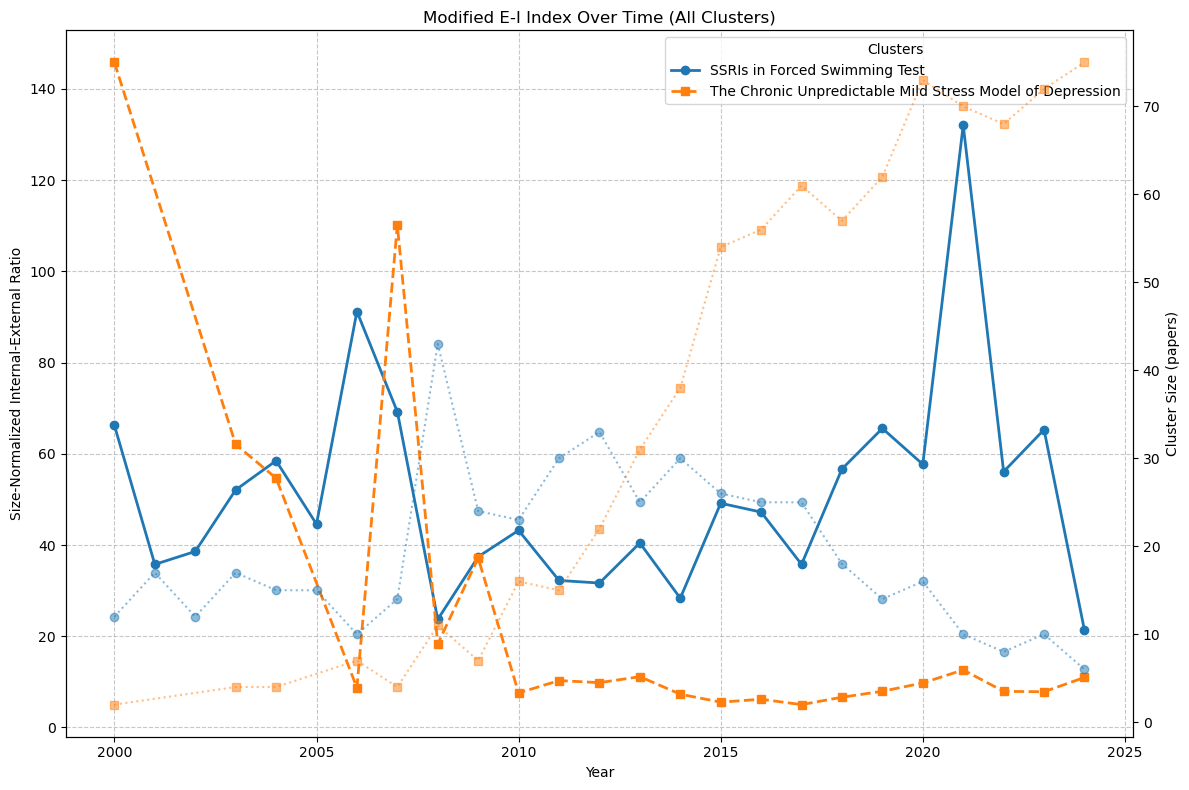

In [170]:
# Define analysis scope
years_of_interest = range(2000, 2025)
clusters_of_interest = [
    "12",  # SSRI in Forced Swimming Test
    "8",  # The Chronic Unpredictable Mild Stress Model of Depression
    # "10",  # Risk of prenatal exposure
]

all_results = analyzer.analyze_all_connections(
    selected_clusters=clusters_of_interest, years_range=years_of_interest
)

# Plot the modified E-I index
analyzer.plot_temporal_evolution(
    all_results,
    metric="size_norm_ie_ratio",
    title="Modified E-I Index Over Time (All Clusters)",
)

Processing year 2000 (subset analysis)...
Processing year 2001 (subset analysis)...
Processing year 2002 (subset analysis)...
Processing year 2003 (subset analysis)...
Processing year 2004 (subset analysis)...
Processing year 2005 (subset analysis)...
Processing year 2006 (subset analysis)...
Processing year 2007 (subset analysis)...
Processing year 2008 (subset analysis)...
Processing year 2009 (subset analysis)...
Processing year 2010 (subset analysis)...
Processing year 2011 (subset analysis)...
Processing year 2012 (subset analysis)...
Processing year 2013 (subset analysis)...
Processing year 2014 (subset analysis)...
Processing year 2015 (subset analysis)...
Processing year 2016 (subset analysis)...
Processing year 2017 (subset analysis)...
Processing year 2018 (subset analysis)...
Processing year 2019 (subset analysis)...
Processing year 2020 (subset analysis)...
Processing year 2021 (subset analysis)...
Processing year 2022 (subset analysis)...
Processing year 2023 (subset analy

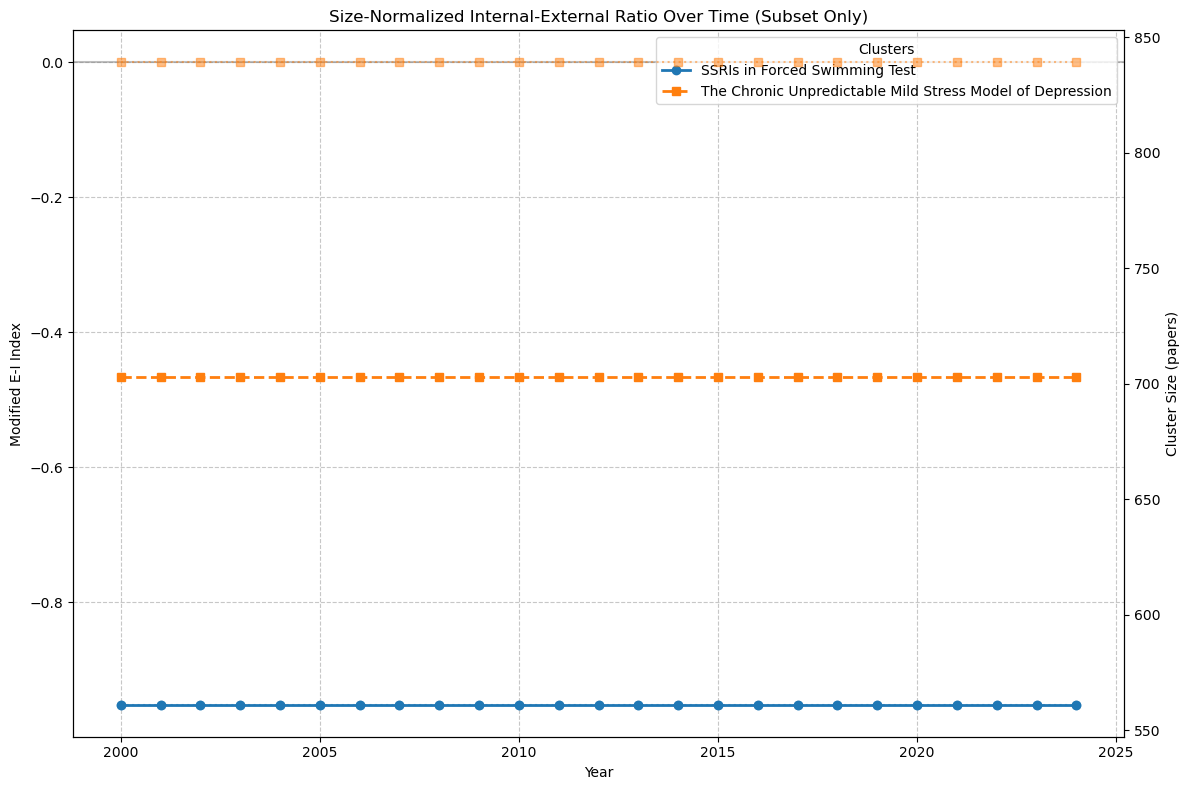

In [171]:
# Run analyses
subset_results = analyzer.analyze_subset_connections(
    selected_clusters=clusters_of_interest, years_range=years_of_interest
)

# Plot the size-normalized ratio
analyzer.plot_temporal_evolution(
    subset_results,
    metric="modified_ei_index",
    title="Size-Normalized Internal-External Ratio Over Time (Subset Only)",
)

In [130]:
all_results["10"].keys()

dict_keys(['internal_count', 'external_count', 'internal_percent', 'external_percent', 'internal_density', 'external_density', 'size_norm_ie_ratio', 'modified_ei_index', 'size'])

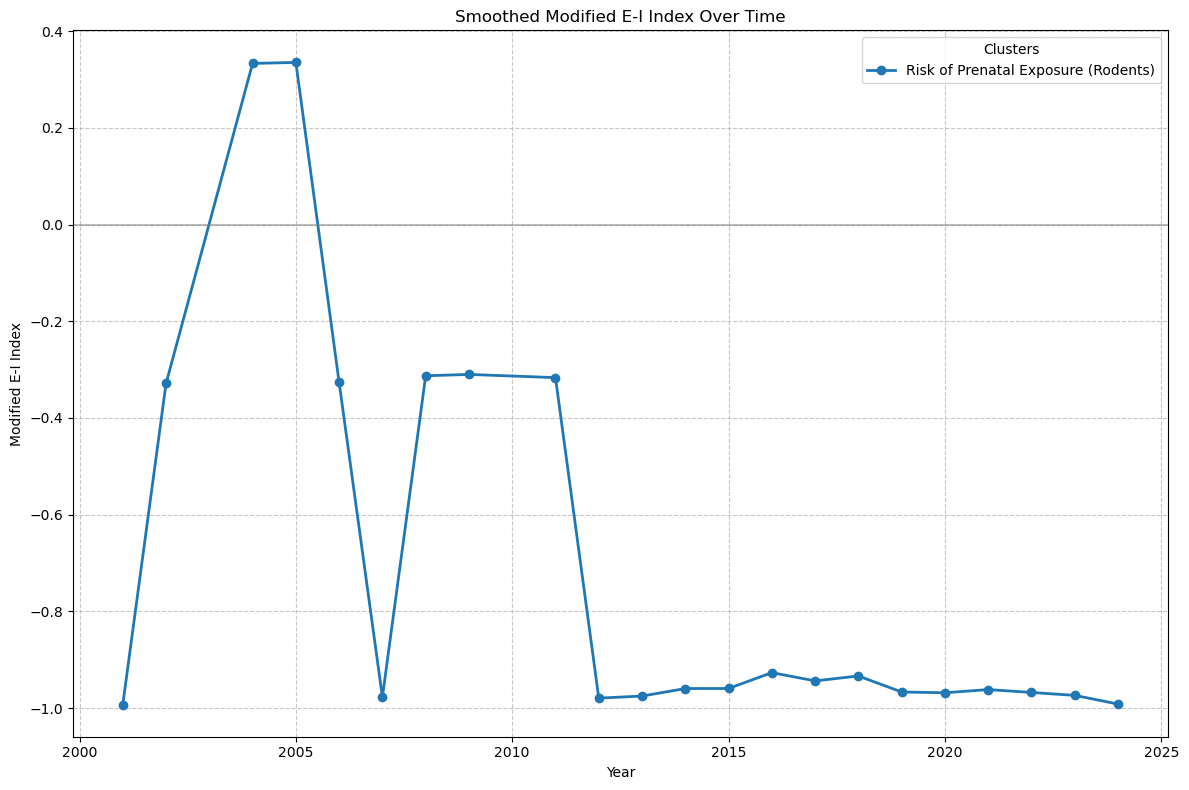

In [134]:
def apply_temporal_smoothing(results, metric, window_size=3):
    """
    Apply a moving average smoothing to metrics over time.

    Args:
        results: Results dictionary
        metric: Metric to smooth
        window_size: Size of the moving average window

    Returns:
        Dictionary with smoothed values
    """
    smoothed_results = {cluster: {metric: {}} for cluster in results}

    for cluster in results:
        years = sorted(results[cluster][metric].keys())
        values = [results[cluster][metric][year] for year in years]

        # Apply moving average
        for i in range(len(years)):
            # Calculate window boundaries
            start = max(0, i - window_size // 2)
            end = min(len(years), i + window_size // 2 + 1)

            # Get values in window
            window_values = [
                v for v in values[start:end] if v is not None and not np.isinf(v)
            ]

            if window_values:
                smoothed_results[cluster][metric][years[i]] = sum(window_values) / len(
                    window_values
                )

    return smoothed_results


smoothed_results = apply_temporal_smoothing(all_results, "modified_ei_index")

# Plot the smoothed results
analyzer.plot_temporal_evolution(
    smoothed_results,
    metric="modified_ei_index",
    title="Smoothed Modified E-I Index Over Time",
)

In [105]:
internal_count = 500
cluster_size = 1000
external_count = 50
internal_ratio = internal_count / cluster_size if cluster_size > 0 else 0
external_ratio = external_count / cluster_size if cluster_size > 0 else 0
print(internal_ratio)
print(external_ratio)

0.5
0.05


In [102]:
subset_results["12"].keys()

dict_keys(['internal_ratio', 'external_ratio', 'internal_percent', 'external_percent', 'size'])

In [86]:
all_results = analyzer.analyze_all_connections(
    selected_clusters=clusters_of_interest, years_range=study_years
)

# Plot internal citation percentages over time
analyzer.plot_temporal_evolution(
    subset_results,
    metric="internal_percent",
    title="Internal Citation % Over Time (Subset Only)",
)

analyzer.plot_temporal_evolution(
    all_results,
    metric="internal_percent",
    title="Internal Citation % Over Time (All Clusters)",
)

# Compare the two approaches
analyzer.plot_comparison(
    subset_results,
    all_results,
    selected_clusters=clusters_of_interest,
    metric="internal_percent",
)

# Create heatmap for a specific year
analyzer.create_heatmap(
    year=2020, selected_clusters=clusters_of_interest, normalize=True
)

# Create stacked bar chart for a year
analyzer.create_stacked_bar_chart(all_results, year=2020, sort_by="internal_percent")

# Save results to CSV
analyzer.save_results_to_csv(subset_results, "subset_analysis")
analyzer.save_results_to_csv(all_results, "all_clusters_analysis")

In [ ]:
# function

In [ ]:
 '12': 'SSRIs in Forced Swimming Test',
 '8': 'The Chronic Unpredictable Mild Stress Model of Depression',


In [88]:
# analyzer.cluster_label_dict

In [66]:
cl_0 = analyzer.df[
    (analyzer.df[analyzer.cluster_col] == "10") & (analyzer.df["year"] > 2005)
]
print(cl_0.shape)

cl_0.year.value_counts()

# get the sum of nr_filtered_references per year
cl_0.nr_filtered_references.sum()
# get the sum of nr_filtered_references per year
total_per_year = cl_0.groupby("year").nr_filtered_references.sum()

(486, 40)


In [67]:
total_per_year[2010]

np.int64(165)

In [68]:
# eids in cluster 0
cl0_eids = cl_0.eid.unique().tolist()

In [69]:
# Initialize dictionaries with default values for each year
internal_citations = {}
external_citations = {}

# Initialize dictionaries with default values for each year
for year in cl_0.year.unique():
    internal_citations[year] = {"total": 0, "percentage": 0}
    external_citations[year] = {"total": 0, "percentage": 0}

for year in cl_0.year.unique():
    # print(year)
    # get all papers from that year
    cl0_year = cl_0[cl_0["year"] == year]

    # Loop through each paper and its references
    for _, row in cl0_year.iterrows():
        if isinstance(row["filtered_reference_eids"], list):
            for eid in row["filtered_reference_eids"]:
                # print(eid)
                if eid in cl0_eids:
                    internal_citations[year]["total"] += 1
                    internal_citations[year]["percentage"] = (
                        internal_citations[year]["total"] / total_per_year[year]
                    )
                else:
                    external_citations[year]["total"] += 1
                    external_citations[year]["percentage"] = (
                        external_citations[year]["total"] / total_per_year[year]
                    )

In [70]:
internal_citations

{np.int32(2006): {'total': 3, 'percentage': np.float64(0.030612244897959183)},
 np.int32(2007): {'total': 5, 'percentage': np.float64(0.058823529411764705)},
 np.int32(2008): {'total': 21, 'percentage': np.float64(0.08267716535433071)},
 np.int32(2009): {'total': 23, 'percentage': np.float64(0.16083916083916083)},
 np.int32(2010): {'total': 28, 'percentage': np.float64(0.1696969696969697)},
 np.int32(2011): {'total': 90, 'percentage': np.float64(0.19522776572668113)},
 np.int32(2012): {'total': 111, 'percentage': np.float64(0.23922413793103448)},
 np.int32(2013): {'total': 187, 'percentage': np.float64(0.34953271028037386)},
 np.int32(2014): {'total': 157, 'percentage': np.float64(0.25950413223140495)},
 np.int32(2015): {'total': 142, 'percentage': np.float64(0.25678119349005424)},
 np.int32(2016): {'total': 330, 'percentage': np.float64(0.34994697773064687)},
 np.int32(2017): {'total': 261, 'percentage': np.float64(0.35655737704918034)},
 np.int32(2018): {'total': 317, 'percentage': n

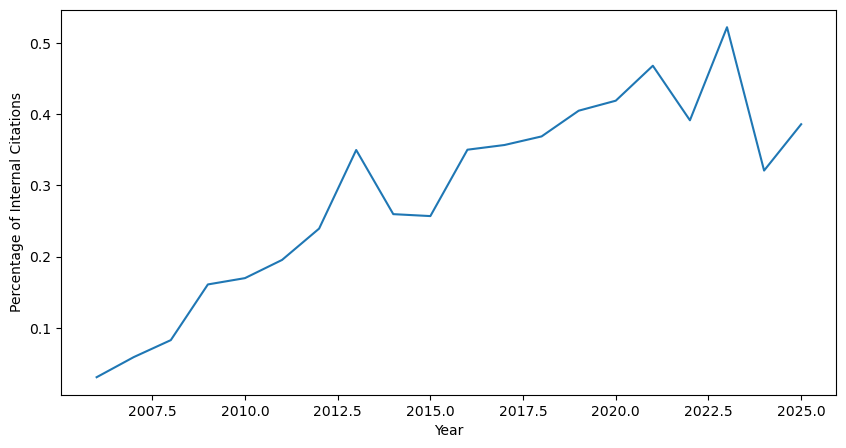

In [71]:
# line plot of percentage of internal citations over time
plt.figure(figsize=(10, 5))
plt.plot(
    internal_citations.keys(), [v["percentage"] for v in internal_citations.values()]
)
plt.xlabel("Year")
plt.ylabel("Percentage of Internal Citations")
plt.show()

In [62]:
internal_citations

{np.int32(2006): {'total': 2, 'percentage': np.float64(0.022727272727272728)},
 np.int32(2007): {'total': 17, 'percentage': np.float64(0.09340659340659341)},
 np.int32(2008): {'total': 42, 'percentage': np.float64(0.22950819672131148)},
 np.int32(2009): {'total': 64, 'percentage': np.float64(0.3368421052631579)},
 np.int32(2010): {'total': 152, 'percentage': np.float64(0.5100671140939598)},
 np.int32(2011): {'total': 131, 'percentage': np.float64(0.5848214285714286)},
 np.int32(2012): {'total': 223, 'percentage': np.float64(0.5837696335078534)},
 np.int32(2013): {'total': 210, 'percentage': np.float64(0.5645161290322581)},
 np.int32(2014): {'total': 607, 'percentage': np.float64(0.6874292185730464)},
 np.int32(2015): {'total': 538, 'percentage': np.float64(0.739010989010989)},
 np.int32(2016): {'total': 654, 'percentage': np.float64(0.7389830508474576)},
 np.int32(2017): {'total': 725, 'percentage': np.float64(0.7413087934560327)},
 np.int32(2018): {'total': 590, 'percentage': np.float

In [63]:
external_citations

{np.int32(2006): {'total': 86, 'percentage': np.float64(0.9772727272727273)},
 np.int32(2007): {'total': 165, 'percentage': np.float64(0.9065934065934066)},
 np.int32(2008): {'total': 141, 'percentage': np.float64(0.7704918032786885)},
 np.int32(2009): {'total': 126, 'percentage': np.float64(0.6631578947368421)},
 np.int32(2010): {'total': 146, 'percentage': np.float64(0.4899328859060403)},
 np.int32(2011): {'total': 93, 'percentage': np.float64(0.41517857142857145)},
 np.int32(2012): {'total': 159, 'percentage': np.float64(0.4162303664921466)},
 np.int32(2013): {'total': 162, 'percentage': np.float64(0.43548387096774194)},
 np.int32(2014): {'total': 276, 'percentage': np.float64(0.31257078142695355)},
 np.int32(2015): {'total': 190, 'percentage': np.float64(0.260989010989011)},
 np.int32(2016): {'total': 231, 'percentage': np.float64(0.26101694915254237)},
 np.int32(2017): {'total': 253, 'percentage': np.float64(0.25869120654396727)},
 np.int32(2018): {'total': 223, 'percentage': np.f

In [21]:
time_results["0"]

{'internal_ratio': {np.int32(2005): np.float64(0.0),
  np.int32(2006): np.float64(0.02040816326530612),
  np.int32(2007): np.float64(0.07111111111111111),
  np.int32(2008): np.float64(0.022684310018903593),
  np.int32(2009): np.float64(0.010416666666666666),
  np.int32(2010): np.float64(0.027434842249657063),
  np.int32(2011): np.float64(0.0027434842249657062),
  np.int32(2012): np.float64(0.002962962962962963),
  np.int32(2013): np.float64(0.007889546351084813),
  np.int32(2014): np.float64(0.020808561236623068),
  np.int32(2015): np.float64(0.0033333333333333335),
  np.int32(2016): np.float64(0.006096631611034903),
  np.int32(2017): np.float64(0.00537109375),
  np.int32(2018): np.float64(0.0029296875),
  np.int32(2019): np.float64(0.006605892456070815),
  np.int32(2020): np.float64(0.005804988662131519),
  np.int32(2021): np.float64(0.005293598666797373),
  np.int32(2022): np.float64(0.007227122967371665),
  np.int32(2023): np.float64(0.004557291666666667),
  np.int32(2024): np.float

In [89]:
analyzer = ClusterAnalyzer(data_dir=data_dir, output_dir=output_dir)
analyzer.load_data()

# 1. Get the available years in the dataset
available_years = sorted(analyzer.df[analyzer.year_column].unique())
available_years = available_years[23:]
print(f"Available years: {available_years}")

# 2. Select some clusters to analyze over time
# You can choose specific clusters or use the top N by size
all_clusters = sorted(analyzer.df[analyzer.cluster_col].unique(), key=int)
selected_clusters = all_clusters[:99]  # Analyze top 5 clusters
print(f"Selected clusters: {selected_clusters}")

# 3. Analyze the selected clusters over time
time_results = analyzer.analyze_cluster_over_time(available_years, selected_clusters)

# 4. Plot the internal ratio evolution over time
analyzer.plot_cluster_evolution(
    time_results,
    metric="internal_ratio",
    title="Evolution of Internal Citation Ratio Over Time",
)

# 5. Plot the external ratio evolution over time
analyzer.plot_cluster_evolution(
    time_results,
    metric="external_ratio",
    title="Evolution of External Citation Ratio Over Time",
)

# 6. You can also plot other metrics
analyzer.plot_cluster_evolution(
    time_results, metric="size", title="Evolution of Cluster Size Over Time"
)

# 7. Plot the density evolution (average connection strength)
analyzer.plot_cluster_evolution(
    time_results,
    metric="density",
    title="Evolution of Cluster Connection Density Over Time",
)

DataFrame loaded with rows: 36510
Cluster labels loaded with 99 entries.
Legend loaded with 4 entries.


AttributeError: 'ClusterAnalyzer' object has no attribute 'year_column'